# **Photography Genre: Lanscape or Portrait**
### **Data Preparing and Modeling Notebook**

Student name: Qi Cai

Student pace: full time

Instructor name: David B. Elliott

**Overview:**
As an fine art photography enthusiast, I am interested in building an photography genres image classification for genres landscape and portrait. This project's target is a bianry output. 0 being landscape and 1 being portrait.


**Business Problem:**
The image classification can aid in organizing and categorizing photography and creating thematic exhibitions for art galleries and museums, with the purposes of increasung efficiency and reducing human labor for catogorizing work.

The result of this project can also enhance online photography platforms by improving search functionality, enabling better content recommendations, and enhancing user experience.

On an individual level, it also helps organize and categorize independent photographers' own images, improve search and discovery, and gain insights into popular genres.

**Stakeholder:**
Curatorial Department or Curatorial Managers of art galleries and online photography platforms.

**Data:**
Over 10K images in total which includes over 5000 portrait images from Unsplash and over 5000 landscape images sourced from Kaggle dataset and Unsplash.

*Data Sources:*
https://www.kaggle.com/datasets/arnaud58/landscape-pictures
https://unsplash.com/s/photos/portrait

*Google Drive Share:* https://drive.google.com/drive/folders/1OtEbHvzK9ffJZBXB_N7YlfEfumWvQTPA?usp=drive_link



### **Import libraries**

In [1]:
# Analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
%matplotlib inline

# Image processing libraries
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import random
import pickle
import cv2
import os

# Modeling libraries and modules
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score, roc_auc_score

# CNN Keras modules
from keras import callbacks
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [2]:
# Import image data from google drive, mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Exploration and Preparation**

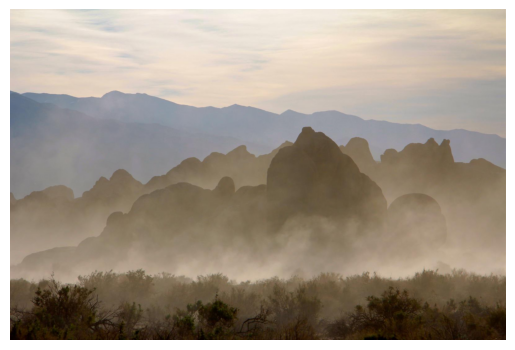

In [3]:
# check an image of landscape
image_path = '/content/drive/MyDrive/data/landscape/00000761.jpg'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB for OpenCV2
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


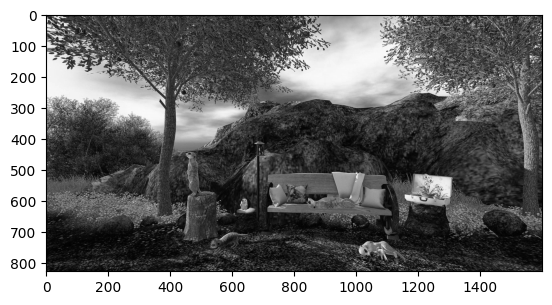

In [5]:
# Merge 2 image folders for lanscape and portrait in the drive

DATADIR = "/content/drive/MyDrive/data"
CATEGORIES = ["landscape","portrait"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap ='gray')
    plt.show()
    break
  break


In [6]:
# check the output of an image
print(img_array)

[[ 54  41  45 ... 101  54  20]
 [  6   0   9 ...  80  15  45]
 [ 97 103 134 ...  14  79 111]
 ...
 [ 20  15   9 ...  33  48  62]
 [ 14   4   1 ...  64  61  50]
 [  2   5  19 ...  68  77  73]]


In [9]:
# check the shape or size of an image
img_array.shape

(826, 1600)

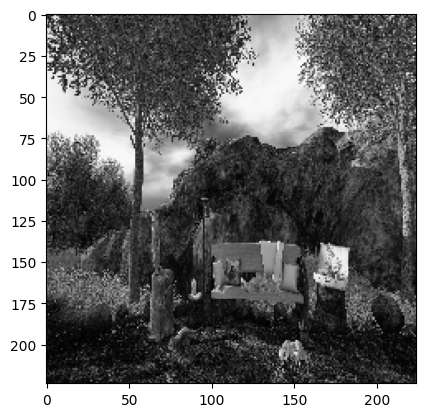

In [15]:
# change size of one image and see how it looks.
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

Decided to go with 224x224 for all images moving forward and set them to gray scale.

In [16]:
# Create a entire dataset with combining all ~5030 landscape and ~5030 portraits and reshape them to 224 x 224, set all to grayscale.
dataset = []

def create_dataset():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category) # labels/index the data to 0 and 1, 0 for landscape, 1 for portrait
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # change to all grey scale
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resize to 224 x 224
        dataset.append([new_array, class_num])
      except Exception as e:
        pass

create_dataset()

In [17]:
# check the amount of images in the dataset
print(len(dataset))

10060


In [18]:
# shuttle or randomize the dataset
random.shuffle(dataset)

In [19]:
# Define our features X and target y
X = []
y = []

In [20]:
# Split dataset to X and y
for features, label in dataset:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,1) # last digit set to 1 is for gray scale

In [21]:
# create pickle files for features and targets

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()


In [22]:
# load X and y
X = pickle.load(open("X.pickle", 'rb'))
y = pickle.load(open("y.pickle", 'rb'))

In [23]:
# Normalize features X
X = X/255.0

In [24]:
# change y from a list to array
y = np.array(y)

In [25]:
# Confirm class balance
# Get the unique values and their counts
unique_values, value_counts = np.unique(y, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 5027
1: 5033


Split the dataset to training, validation, and testing sets

In [26]:
# 0.15 for testing, 0.15 for validation, and 0.7 for training.

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.176, random_state = 42)

### **Start Modeling**
### Dummy Model
First, we want to come up with a dummy model as a baseline model use to compare with other models down the road. I will use dummy classifier for this.

In [27]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_val)

In [28]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       781
           1       0.00      0.00      0.00       724

    accuracy                           0.52      1505
   macro avg       0.26      0.50      0.34      1505
weighted avg       0.27      0.52      0.35      1505



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
accuracy_score(y_val, y_pred)

0.518936877076412

**This Dummy Classifier has a 51.9% accuracy on predicting correctly if a landscape photograph is classified indeed as landscape. This model is pretty bad but we can use this dummy model as a baseline to compare models.**

### Create first CNN model: 2 convolutional layers, 1 dense layer.

In [30]:
# Create a Sequential model
model1 = Sequential()

# Add 2 convolutional layers
model1.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224, 1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
#model1.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output from the previous layer
model1.add(Flatten())

# Add one dense (fully connected) layer
model1.add(Dense(64, activation='relu'))

# Add the output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model on the training and validate on the validation set
results1 = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
221/221 [==============================] - 16s 25ms/step - loss: 0.3162 - accuracy: 0.8842 - val_loss: 0.2605 - val_accuracy: 0.8944
Epoch 2/50
221/221 [==============================] - 4s 20ms/step - loss: 0.1208 - accuracy: 0.9640 - val_loss: 0.1550 - val_accuracy: 0.9442
Epoch 3/50
221/221 [==============================] - 4s 20ms/step - loss: 0.0869 - accuracy: 0.9730 - val_loss: 0.0678 - val_accuracy: 0.9767
Epoch 4/50
221/221 [==============================] - 4s 20ms/step - loss: 0.0581 - accuracy: 0.9811 - val_loss: 0.1257 - val_accuracy: 0.9608
Epoch 5/50
221/221 [==============================] - 4s 20ms/step - loss: 0.0369 - accuracy: 0.9871 - val_loss: 0.0710 - val_accuracy: 0.9728
Epoch 6/50
221/221 [==============================] - 4s 20ms/step - loss: 0.0238 - accuracy: 0.9939 - val_loss: 0.0697 - val_accuracy: 0.9794
Epoch 7/50
221/221 [==============================] - 4s 20ms/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.1154 - val_accuracy: 0.968

Visualizations for loss and accuracy to compare training and validation

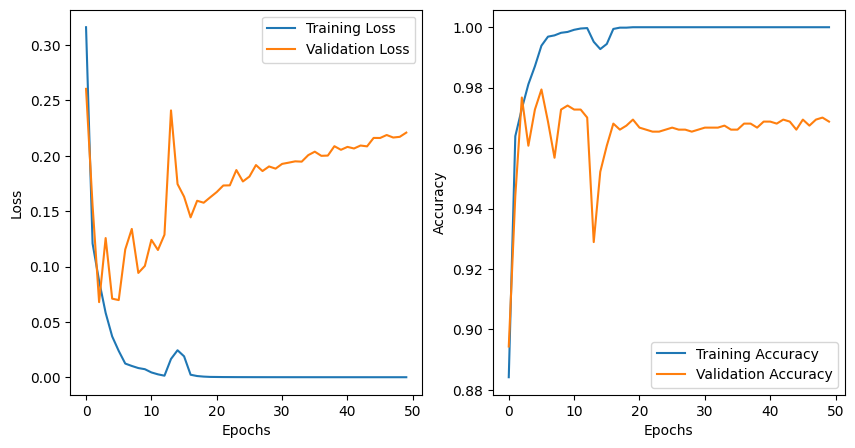

In [31]:
# define values we are looking to compare: loss and accurary
train_loss = results1.history['loss']
train_accuracy = results1.history['accuracy']

val_loss = results1.history['val_loss']
val_accuracy = results1.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results1.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results1.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results1.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results1.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()



In [32]:
val_loss, val_acc = model1.evaluate(X_val, y_val)

48/48 [==============================] - 0s 7ms/step - loss: 0.2210 - accuracy: 0.9688


The first cnn model is extremely overfit comparing loss and accuracy between training and validation results. Overall the model has improved from 0.5 to 0.97 in accuracy compared to the dummy model.

Ways to improve:
1. Use Augmentation to increase the diversity of the training data.
2. Add regularizations (L2) and dropout
3. Add early stopping
4. Model complexity reduction: decreasing the number of layers, reducing the number of filters, or using smaller filter sizes.

### Add Augmentation to the training images




In [33]:
# Use ImageDataGenerator to define augmentation parameters

aug1 = ImageDataGenerator(
    rotation_range=20, # rotate images randomly up to 20 degrees
    width_shift_range=0.2, #shift image horizontally by a fraction of the total width
    height_shift_range=0.2, #shift image vertically by a fraction of the total height
    brightness_range=None,
    shear_range=0.2, # apply shear transformation
    zoom_range=0.2, # zoom in / out on image
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip= True, # flip images both horizontally and vertically to increase diversity
    vertical_flip= True
)

# Apply augmentation on training data
train_generator1 = aug1.flow(X_train, y_train, batch_size = 32)

In [34]:
# Try again on Model1 but with augmentation
results2 = model1.fit_generator(train_generator1,
          epochs = 50,
          validation_data = (X_val, y_val))

Epoch 1/50


<ipython-input-34-aa15626c3ac1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results2 = model1.fit_generator(train_generator1,


221/221 [==============================] - 24s 107ms/step - loss: 0.3711 - accuracy: 0.8903 - val_loss: 0.1385 - val_accuracy: 0.9628
Epoch 2/50
221/221 [==============================] - 23s 102ms/step - loss: 0.1771 - accuracy: 0.9441 - val_loss: 0.2179 - val_accuracy: 0.9296
Epoch 3/50
221/221 [==============================] - 23s 104ms/step - loss: 0.1573 - accuracy: 0.9489 - val_loss: 0.1309 - val_accuracy: 0.9654
Epoch 4/50
221/221 [==============================] - 23s 102ms/step - loss: 0.1522 - accuracy: 0.9537 - val_loss: 0.1002 - val_accuracy: 0.9701
Epoch 5/50
221/221 [==============================] - 23s 104ms/step - loss: 0.1436 - accuracy: 0.9516 - val_loss: 0.1647 - val_accuracy: 0.9575
Epoch 6/50
221/221 [==============================] - 23s 103ms/step - loss: 0.1296 - accuracy: 0.9591 - val_loss: 0.1490 - val_accuracy: 0.9641
Epoch 7/50
221/221 [==============================] - 23s 103ms/step - loss: 0.1306 - accuracy: 0.9573 - val_loss: 0.1558 - val_accuracy: 0.9

#### Loss and Accuracy Visualization: Model1 with augmentation

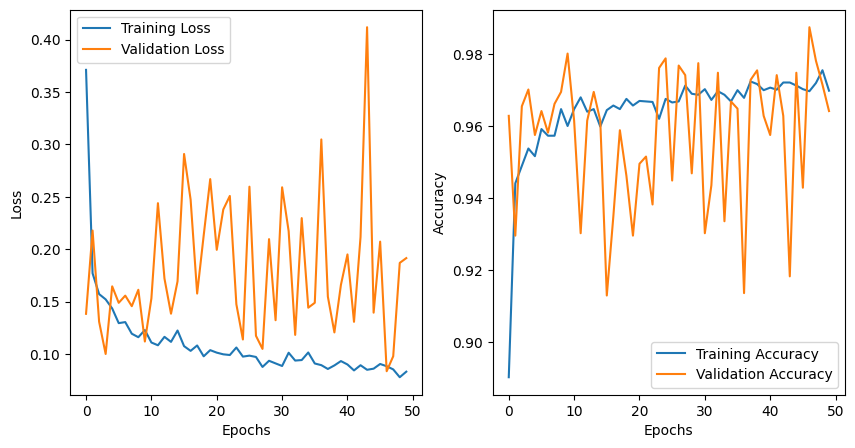

In [35]:
train_loss = results2.history['loss']
train_accuracy = results2.history['accuracy']

val_loss = results2.history['val_loss']
val_accuracy = results2.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results2.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results2.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results2.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results2.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

In [36]:
# Save the augmentation configuration
with open("augmentation_config1.pkl", "wb") as file:
    pickle.dump(aug1, file)

In [37]:
# Load the augmentation configuration
with open("augmentation_config1.pkl", "rb") as file:
    aug = pickle.load(file)

In [64]:
# download augmentation pickle file
files.download("augmentation_config1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
# Make predictions with model1
y_pred_prob = model1.predict(X_val)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)
print(y_pred)

48/48 [==============================] - 0s 6ms/step
[[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


In [39]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       781
           1       1.00      0.93      0.96       724

    accuracy                           0.96      1505
   macro avg       0.97      0.96      0.96      1505
weighted avg       0.97      0.96      0.96      1505



In [40]:
val_loss, val_acc = model1.evaluate(X_val, y_val)

48/48 [==============================] - 0s 7ms/step - loss: 0.1916 - accuracy: 0.9641


Model1 conclusion:


without augmentation:
loss: 2.0074e-06 - accuracy: 1.0000 - val_loss: 0.2210 - val_accuracy: 0.9688

with augmentation:
loss: 0.0833 - accuracy: 0.9698 - val_loss: 0.1916 - val_accuracy: 0.9641

Compared to the first model with no augmentation, with augmentation, validation loss has improved by 0.04. Model overall reduced overfitting compared training and validation.




To further improve the model, we can try to tweak the numbers of layers (both convolutional layer and dense layer).

### Model 2: 3 convolutional layers and 0 dense layer with augmentation.

In [41]:
# Create the convolutional base
model2 = Sequential()
model2.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224,224, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2))) # 1st convolutional layer

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) # 2nd convolutional layer

model2.add(Conv2D(64, (3, 3), activation='relu')) # 3rd convolutional layer
model2.add(MaxPooling2D(pool_size=(2, 2)))


# Add Dense layers on top
model2.add(Flatten()) # no dense layer

# Add output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# fit the model with augmentation
results3 = model2.fit_generator(train_generator1,
          epochs = 50,
          validation_data = (X_val, y_val))

Epoch 1/50


<ipython-input-41-5ba4a0b21ccb>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results3 = model2.fit_generator(train_generator1,


221/221 [==============================] - 28s 116ms/step - loss: 0.3326 - accuracy: 0.8484 - val_loss: 0.1149 - val_accuracy: 0.9615
Epoch 2/50
221/221 [==============================] - 27s 124ms/step - loss: 0.2186 - accuracy: 0.9297 - val_loss: 0.1612 - val_accuracy: 0.9502
Epoch 3/50
221/221 [==============================] - 24s 109ms/step - loss: 0.2143 - accuracy: 0.9307 - val_loss: 0.0871 - val_accuracy: 0.9714
Epoch 4/50
221/221 [==============================] - 24s 109ms/step - loss: 0.1919 - accuracy: 0.9385 - val_loss: 0.1701 - val_accuracy: 0.9522
Epoch 5/50
221/221 [==============================] - 24s 110ms/step - loss: 0.1720 - accuracy: 0.9479 - val_loss: 0.1402 - val_accuracy: 0.9535
Epoch 6/50
221/221 [==============================] - 25s 112ms/step - loss: 0.1513 - accuracy: 0.9536 - val_loss: 0.1310 - val_accuracy: 0.9575
Epoch 7/50
221/221 [==============================] - 25s 111ms/step - loss: 0.1595 - accuracy: 0.9498 - val_loss: 0.0738 - val_accuracy: 0.9

#### Loss and Accuracy Visualization: Model2 with augmentation.

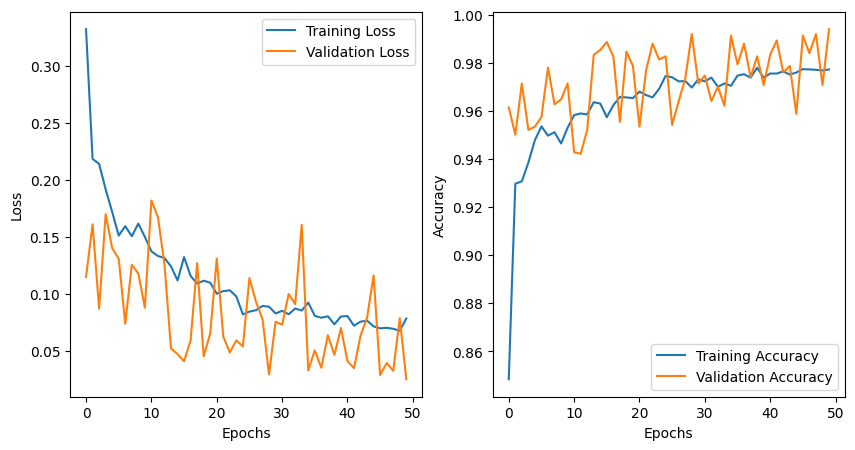

In [42]:
train_loss = results3.history['loss']
train_accuracy = results3.history['accuracy']

val_loss = results3.history['val_loss']
val_accuracy = results3.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results3.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results3.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results3.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results3.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Model 2 improves a lot in loss and accuracy **with 3 convolutional layers and 0 dense layer while keeping the the augmentation** constant.
Comparing this model with model1 with augmentation:

Model1 with augmentation:
loss: 0.0833 - accuracy: 0.9698 - val_loss: 0.1916 - val_accuracy: 0.9641

new model:
loss: 0.0784 - accuracy: 0.9773 - val_loss: 0.0251 - val_accuracy: 0.9940


This model also reduced overfitting!

#### We can further look into classification report to evaluate the model:

In [43]:
# make prediction on X_val
y_pred_prob = model2.predict(X_val)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# print out classification report
print (classification_report(y_val, y_pred))

48/48 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       781
           1       1.00      0.99      0.99       724

    accuracy                           0.99      1505
   macro avg       0.99      0.99      0.99      1505
weighted avg       0.99      0.99      0.99      1505



In [44]:
# check ROC curve and AOC score
roc_auc_score(y_val, y_pred)

0.9938853361252398

**Conclusion: Looking at the classification report and auc score of the current model with 3 convolutional layers, no dense layer, with augmentation, 50 epochs, the model performs the best so far.**

## **Final Evaluation on Unseen data/ testing data**

We can now combine the training and validation sets as the traning set to rerun this model and use the testing data to see how this model performs on unseen data!

If the model is overfit, then apply regularization, and dropout.

In [45]:
# Apply same augmentation on training and validation data
train_generator2 = aug1.flow(X_train_val, y_train_val, batch_size = 64) # update batch size to 64 to increase speed

In [46]:
# run the model with augmentation
results4 = model2.fit_generator(train_generator2,
          epochs = 50,
          validation_data = (X_test, y_test)) # final validation on test

<ipython-input-46-bf03fb43d199>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results4 = model2.fit_generator(train_generator2,


Epoch 1/50
134/134 [==============================] - 33s 227ms/step - loss: 0.0528 - accuracy: 0.9835 - val_loss: 0.0958 - val_accuracy: 0.9775
Epoch 2/50
134/134 [==============================] - 29s 219ms/step - loss: 0.0540 - accuracy: 0.9830 - val_loss: 0.1343 - val_accuracy: 0.9689
Epoch 3/50
134/134 [==============================] - 29s 213ms/step - loss: 0.0555 - accuracy: 0.9829 - val_loss: 0.0957 - val_accuracy: 0.9735
Epoch 4/50
134/134 [==============================] - 28s 210ms/step - loss: 0.0560 - accuracy: 0.9826 - val_loss: 0.1089 - val_accuracy: 0.9689
Epoch 5/50
134/134 [==============================] - 28s 211ms/step - loss: 0.0566 - accuracy: 0.9802 - val_loss: 0.0708 - val_accuracy: 0.9788
Epoch 6/50
134/134 [==============================] - 28s 212ms/step - loss: 0.0596 - accuracy: 0.9801 - val_loss: 0.1220 - val_accuracy: 0.9636
Epoch 7/50
134/134 [==============================] - 29s 214ms/step - loss: 0.0510 - accuracy: 0.9836 - val_loss: 0.0821 - val_ac

### Final evaluation visualization on Model2 loss and accuracy

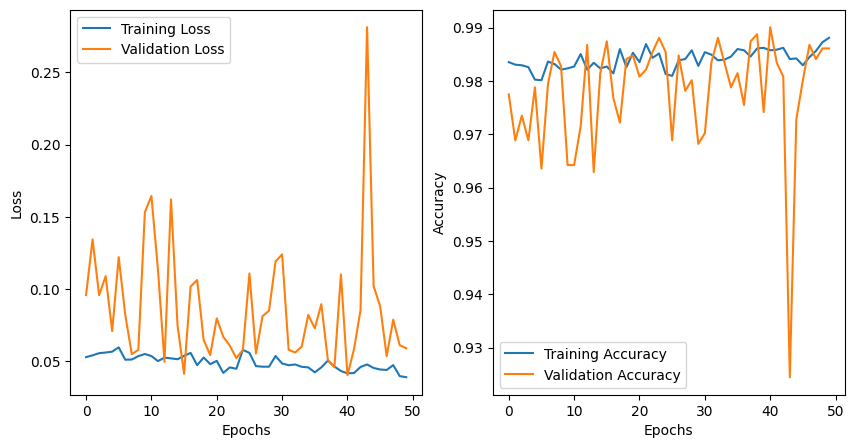

In [47]:
train_loss = results4.history['loss']
train_accuracy = results4.history['accuracy']

val_loss = results4.history['val_loss']
val_accuracy = results4.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results4.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results4.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results4.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results4.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

In [48]:
# make prediction on X_test
y_pred_prob = model2.predict(X_test)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# print classification report
print (classification_report(y_test, y_pred))

48/48 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       722
           1       0.99      0.98      0.99       787

    accuracy                           0.99      1509
   macro avg       0.99      0.99      0.99      1509
weighted avg       0.99      0.99      0.99      1509



In [49]:
# check ROC curve and AOC score
roc_auc_score(y_test, y_pred)

0.9863722118779192

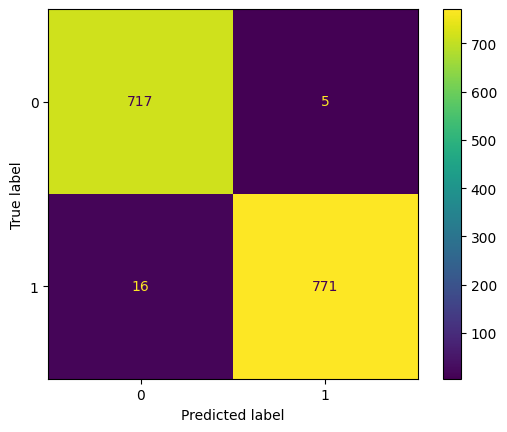

In [50]:
cm_model2 = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_model2)
disp.plot()
plt.show()

### Evaluating Model2, looking at the results on the testing set, I think overall the model performs very well with an accuracy of 98.6% and with an auc score of 0.986 but I can apply regularization to see if the model be less over-fit and stabilized.

### Model3: 3 convolutional layers, 0 dense layer, apply L2 regularization on first convolutional layer.

In [51]:
# Create the convolutional base
model3 = Sequential()

model3.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(224,224, 1),
                        kernel_regularizer = l2(0.01))) # add L2 regularization on the first convolutional layer
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))


# Add Dense layers on top
model3.add(Flatten())
#model2.add(Dense(64, activation='relu')) #remove dense layer

# Add output layer
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


# fit the model with augmentation
results5 = model3.fit_generator(train_generator2,
          epochs = 50,
          validation_data = (X_test, y_test))

<ipython-input-51-1979c3846e73>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results5 = model3.fit_generator(train_generator2,


Epoch 1/50
134/134 [==============================] - 31s 216ms/step - loss: 0.3675 - accuracy: 0.8381 - val_loss: 0.1823 - val_accuracy: 0.9536
Epoch 2/50
134/134 [==============================] - 28s 211ms/step - loss: 0.2127 - accuracy: 0.9340 - val_loss: 0.1734 - val_accuracy: 0.9602
Epoch 3/50
134/134 [==============================] - 28s 210ms/step - loss: 0.1866 - accuracy: 0.9447 - val_loss: 0.2410 - val_accuracy: 0.9410
Epoch 4/50
134/134 [==============================] - 28s 210ms/step - loss: 0.2063 - accuracy: 0.9370 - val_loss: 0.1865 - val_accuracy: 0.9549
Epoch 5/50
134/134 [==============================] - 29s 212ms/step - loss: 0.1816 - accuracy: 0.9445 - val_loss: 0.1387 - val_accuracy: 0.9629
Epoch 6/50
134/134 [==============================] - 28s 210ms/step - loss: 0.1716 - accuracy: 0.9487 - val_loss: 0.1588 - val_accuracy: 0.9576
Epoch 7/50
134/134 [==============================] - 28s 209ms/step - loss: 0.1740 - accuracy: 0.9505 - val_loss: 0.1317 - val_ac

Plot it out:

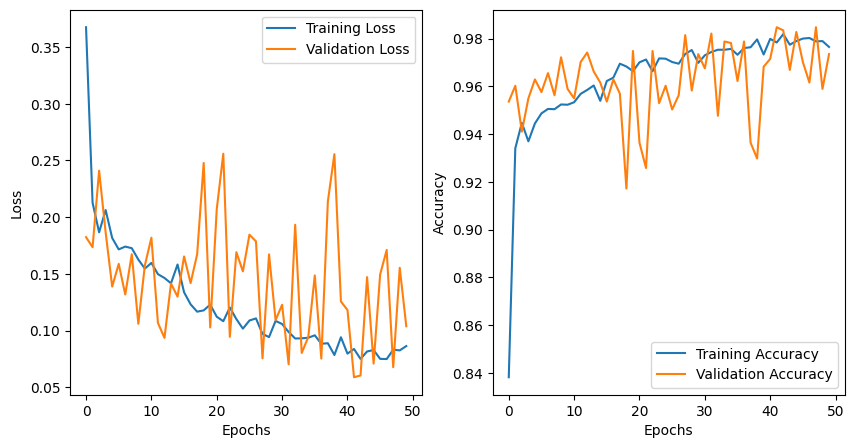

In [52]:
train_loss = results5.history['loss']
train_accuracy = results5.history['accuracy']

val_loss = results5.history['val_loss']
val_accuracy = results5.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results5.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results5.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results5.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results5.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

In [53]:
# make prediction on X_test with model3
y_pred_prob = model3.predict(X_test)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# print out classification report for model3
print (classification_report(y_test, y_pred))

48/48 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       722
           1       1.00      0.95      0.97       787

    accuracy                           0.97      1509
   macro avg       0.97      0.97      0.97      1509
weighted avg       0.97      0.97      0.97      1509



In [54]:
# check ROC curve and AOC score
roc_auc_score(y_test, y_pred)

0.9744726458693379

Conclusion:
Comparing model3's results with model2's, this model with
regularization does not seem to improve overall model performance.
model2:
loss: 0.0389 - accuracy: 0.9881 - val_loss: 0.0589 - val_accuracy: 0.9861

model3:
loss: 0.0863 - accuracy: 0.9765 - val_loss: 0.1037 - val_accuracy: 0.9735

Both loss and accuracy on testing set did not improve. We want to stick with model2.

In [55]:
# save model2 for streamlit demo
tf.keras.models.save_model(model2,'my_model2.h5')
# save model2 as pickle file too
with open("model2.pkl", "wb") as file:
    pickle.dump(model2, file)

In [56]:
from google.colab import files

files.download("model2.pkl")
files.download("my_model2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Final model Evaluation**
Final model I decided to go with is Model2 which is a cnn model with 3 convoltional layers, 0 dense layer, 1 output layer, with augmentation, and no regularization. My reason is this model yields the **highest validation accuracy score and lowest validation loss ***compared to the other models I've tried.

In [57]:
final_model = model2

In [58]:
# display infomation of the final model
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 64)      

 evaluated using holdout test data.

In [59]:
final_results = model2.fit_generator(train_generator2,
          epochs = 50)

<ipython-input-59-5c7fc04633fa>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_results = model2.fit_generator(train_generator2,


Epoch 1/50
134/134 [==============================] - 28s 209ms/step - loss: 0.0398 - accuracy: 0.9873
Epoch 2/50
134/134 [==============================] - 28s 207ms/step - loss: 0.0395 - accuracy: 0.9868
Epoch 3/50
134/134 [==============================] - 31s 229ms/step - loss: 0.0445 - accuracy: 0.9870
Epoch 4/50
134/134 [==============================] - 29s 216ms/step - loss: 0.0401 - accuracy: 0.9862
Epoch 5/50
134/134 [==============================] - 29s 217ms/step - loss: 0.0432 - accuracy: 0.9864
Epoch 6/50
134/134 [==============================] - 28s 210ms/step - loss: 0.0414 - accuracy: 0.9874
Epoch 7/50
134/134 [==============================] - 28s 207ms/step - loss: 0.0458 - accuracy: 0.9853
Epoch 8/50
134/134 [==============================] - 31s 229ms/step - loss: 0.0415 - accuracy: 0.9867
Epoch 9/50
134/134 [==============================] - 29s 212ms/step - loss: 0.0395 - accuracy: 0.9878
Epoch 10/50
134/134 [==============================] - 28s 205ms/step - l

In [60]:
# make final prediction on holdout test set
y_pred_prob = final_model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# print final classification report
final_report = print (classification_report(y_test, y_pred))
final_report

48/48 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       722
           1       0.99      0.99      0.99       787

    accuracy                           0.99      1509
   macro avg       0.99      0.99      0.99      1509
weighted avg       0.99      0.99      0.99      1509



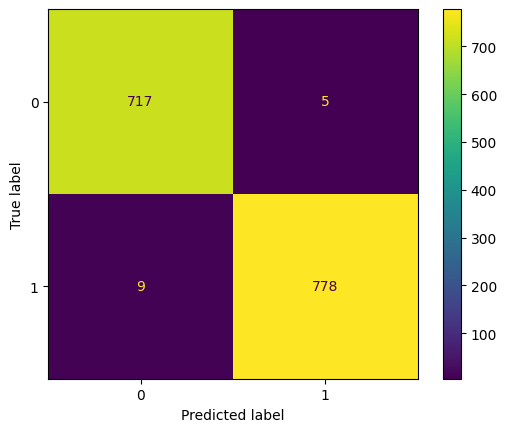

In [61]:
# display confusion matrix
final_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = final_cm)
disp.plot()
plt.show()

In [63]:
test_loss, test_acc = model2.evaluate(X_test, y_test)


48/48 [==============================] - 1s 19ms/step - loss: 0.0364 - accuracy: 0.9907


# **Final Model Evaluation Conclusion:**

After some modeling, the best model seems to be model2, a convolutional neural net with 3 convolutional layers and 0 dense layer. I also included augmentation and that reduced over-fitting greatly. The model yields a validation loss of 0.0364 and a validation accuracy of 99.07%.
I chose accuracy as my metric since accuracy is the percentage of results that have the correct predicted answer. Results show that an accuracy of 99.07% meaning 99.07% of both images are correctly identified as portrait or landscape.

Accuracy = (True landscape + True portrait)/ (True landscape + True portrait + False identified landscape + False identified portrait)

# **Recommedations / Next Steps:**
My next step would be model deployment, and develop good UX/UI.

Continuously evaluate and monitor the model's performance to ensure the model maintains high accuracy over time.

Fine-tuning or retraining the model periodically with new data may also be necessary to adapt to evolving trends and changes in user preferences.

Expand 2 genres into human portrait, animal portrait, natural landscape, and urban landscape for more specific classifications.




## Streamlit Demo (Work in Progress)

In [ ]:
# !pip install streamlit

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st
import cv2
from PIL import Image, ImageOps

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)


def load_model():
	model  = tf.keras.models.load_model('/content/my_model3.hdf5')
	return model
with st.spinner('Model is being loaded..'):
  model=load_model()

def predict_class(image, model):
    resized_image = cv2.reszie(image, (224,224))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    normalized_image = gray_image / 255.0
    reshaped_image = np.array(normalized_image).reshape(-1, 224, 224, 1)
    y_pred_prob = model.predict(reshaped_image)
    threshold = 0.5
    prediction = (y_pred_prob > threshold).astype(int)
    return prediction


model = load_model()
st.title('Photography Genre Classifier')

file = st.file_uploader("Upload a portrait or a landscape image", type=["jpg", "png"])


if file is None:
	st.text('Waiting for upload....')

else:
	slot = st.empty()
	slot.text('Running inference....')

	test_image = Image.open(file)

	st.image(test_image, caption="Input Image", width = 400)

	pred = predict_class(np.asarray(test_image), model)

	class_names = ['landscape', 'portrait']

	result = class_names[np.argmax(pred)]

	output = 'The photograph is a ' + result

	slot.text('Done')

	st.success(output)

Writing app.py


In [ ]:
# !streamlit run app.py &>/dev/null&

In [ ]:
#!pip install pyngrok

In [ ]:
# !ngrok authtoken 2SIoMfkHhaji0CnU9HXHzCmqc6Z_71sNUwPjcUWvxWSnorCsX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
#from pyngrok import ngrok

In [ ]:
#!streamlit run app.py&>/dev/null&